In [1]:
import boto3
import pandas as pd
from io import StringIO

# AWS S3 configuration
BUCKET_NAME = 'tmdbonemillionmovieanalysis'
FILE_KEY = 'TMDB_movie_dataset_v11.csv'

# Initialize boto3 client
s3 = boto3.client('s3')

def download_csv_from_s3(bucket, key):
    """
    Download a CSV file from an S3 bucket and load it into a pandas DataFrame.
    """
    try:
        # Get the object from S3
        obj = s3.get_object(Bucket=bucket, Key=key)
        # Read the object's content into a pandas DataFrame
        data = obj['Body'].read().decode('utf-8')
        df = pd.read_csv(StringIO(data))
        return df
    except Exception as e:
        print(f"Error downloading file from S3: {e}")
        return None

# Download the CSV file from S3 and load it into a DataFrame
df = download_csv_from_s3(BUCKET_NAME, FILE_KEY)

# Display the first few rows of the DataFrame
if df is not None:
    print(df.head())

       id            title  vote_average  vote_count    status release_date  \
0   27205        Inception         8.364       34495  Released   2010-07-15   
1  157336     Interstellar         8.417       32571  Released   2014-11-05   
2     155  The Dark Knight         8.512       30619  Released   2008-07-16   
3   19995           Avatar         7.573       29815  Released   2009-12-15   
4   24428     The Avengers         7.710       29166  Released   2012-04-25   

      revenue  runtime  adult                     backdrop_path  ...  \
0   825532764      148  False  /8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg  ...   
1   701729206      169  False  /pbrkL804c8yAv3zBZR4QPEafpAR.jpg  ...   
2  1004558444      152  False  /nMKdUUepR0i5zn0y1T4CsSB5chy.jpg  ...   
3  2923706026      162  False  /vL5LR6WdxWPjLPFRLe133jXWsh5.jpg  ...   
4  1518815515      143  False  /9BBTo63ANSmhC4e6r62OJFuK2GL.jpg  ...   

    original_title                                           overview  \
0        Inception 

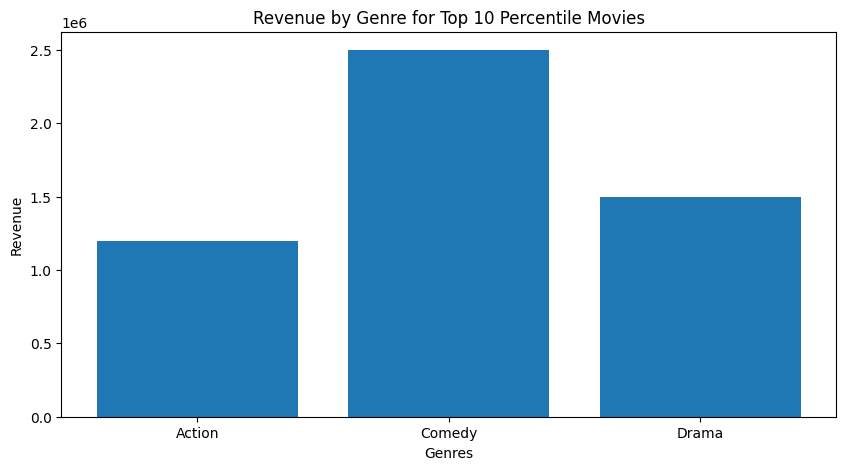

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure your DataFrame (top_10_percentile_movies) is similar in structure
data = {
    'genres': ['Action', 'Comedy', 'Drama', 'Action', 'Comedy'],
    'revenue': [1000000, 2000000, 1500000, 1200000, 2500000]
}
top_10_percentile_movies = pd.DataFrame(data)

# Ensure 'genres' is of type string and 'revenue' is of type float
top_10_percentile_movies['genres'] = top_10_percentile_movies['genres'].astype(str)
top_10_percentile_movies['revenue'] = top_10_percentile_movies['revenue'].astype(float)

# Check for NaN values and handle them if necessary
top_10_percentile_movies.dropna(subset=['genres', 'revenue'], inplace=True)

# Plotting the bar chart
plt.figure(figsize=(10, 5))
plt.bar(top_10_percentile_movies['genres'], top_10_percentile_movies['revenue'])
plt.xlabel('Genres')
plt.ylabel('Revenue')
plt.title('Revenue by Genre for Top 10 Percentile Movies')
plt.show()


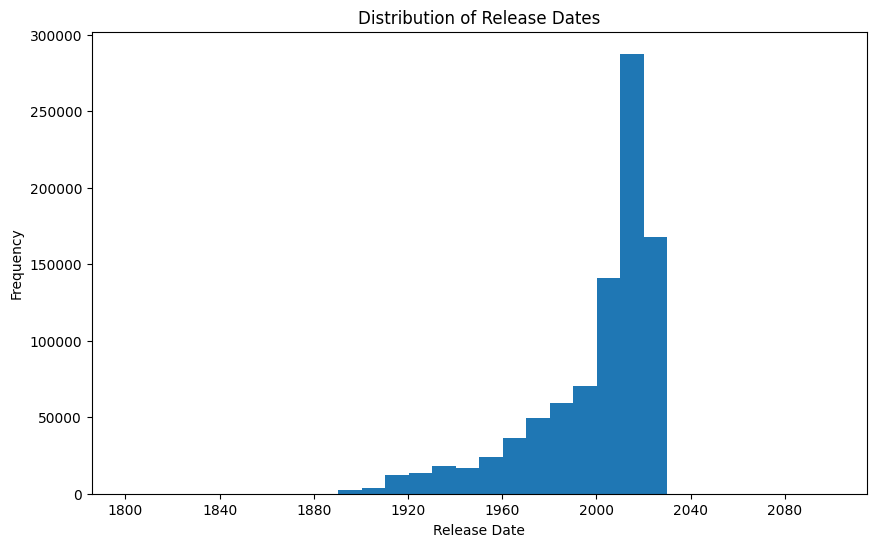

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Convert the 'release_date' column to datetime
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# Remove rows where 'release_date' could not be parsed
df = df.dropna(subset=['release_date'])
# Calculate the difference in days between consecutive release dates
df['time_diff'] = df['release_date'].diff().dt.days
# Plot the distribution of release dates
plt.figure(figsize=(10, 6))
plt.hist(df['release_date'], bins=30)
plt.title('Distribution of Release Dates')
plt.xlabel('Release Date')
plt.ylabel('Frequency')
plt.show()


Potential outliers in release dates:
        release_date  time_diff
321       1960-06-22   -22295.0
436       1957-04-10   -23499.0
514       1937-12-21   -29388.0
515       2011-05-11    26804.0
598       1950-02-22   -24675.0
...              ...        ...
1034360   2020-03-10    35634.0
1034388   1929-10-28   -32206.0
1034389   2009-10-26    29218.0
1034404   1909-08-30   -33727.0
1034405   2020-03-11    40371.0

[126335 rows x 2 columns]


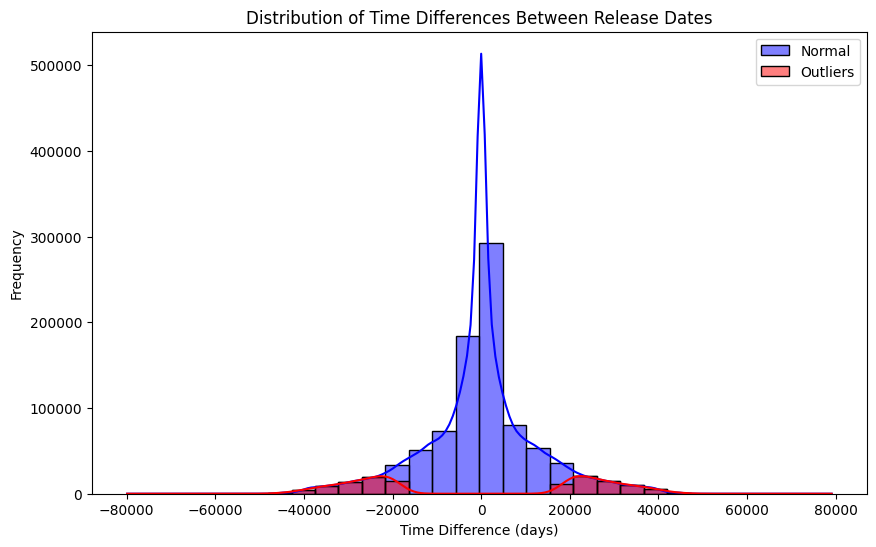

In [11]:
# Step 1: Ensure 'release_date' is in datetime format
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# Step 2: Calculate Time Differences
df['time_diff'] = df['release_date'].diff().dt.days

# Step 3: Remove NaN values in 'time_diff'
df_clean = df.dropna(subset=['time_diff'])

# Step 4: Calculate IQR
Q1 = df_clean['time_diff'].quantile(0.25)
Q3 = df_clean['time_diff'].quantile(0.75)
IQR = Q3 - Q1

# Step 5: Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 6: Filter outliers
outliers_iqr = df_clean[(df_clean['time_diff'] < lower_bound) | (df_clean['time_diff'] > upper_bound)]

print("Potential outliers in release dates:")
print(outliers_iqr[['release_date', 'time_diff']])

# Optional: Visualize the outliers
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['time_diff'], bins=30, kde=True, color='blue', label='Normal')
sns.histplot(outliers_iqr['time_diff'], bins=30, kde=True, color='red', label='Outliers')
plt.title('Distribution of Time Differences Between Release Dates')
plt.xlabel('Time Difference (days)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

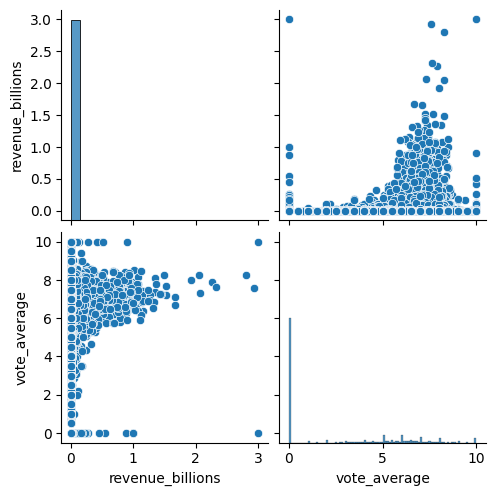

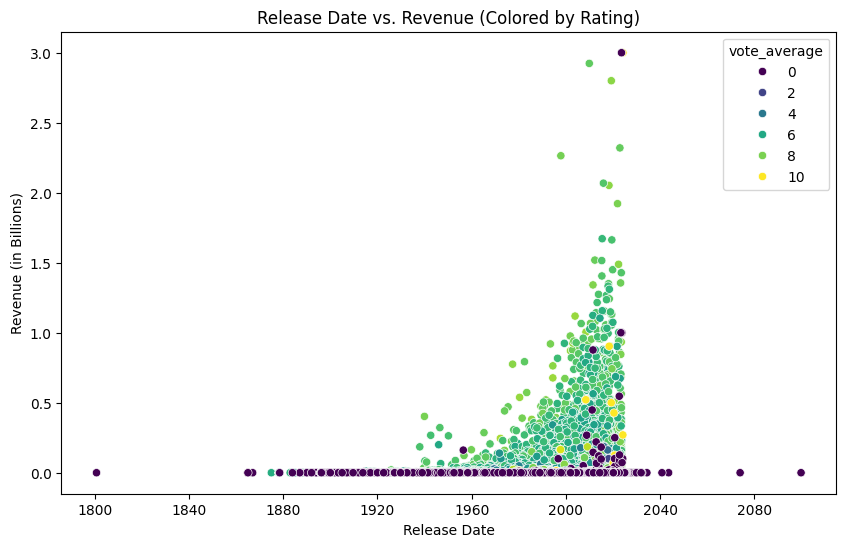

In [13]:
# Convert 'revenue' to numeric if it's not already
df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce')

# Convert revenue to billions
df['revenue_billions'] = df['revenue'] / 1e9

# Remove rows where 'revenue' or 'vote_average' is NaN (if they exist)
df = df.dropna(subset=['revenue', 'vote_average'])

# Pairplot for release_date, revenue, and vote_average
sns.pairplot(df[['release_date', 'revenue_billions', 'vote_average']])
plt.show()

# Scatterplot for release date vs. revenue colored by vote average
plt.figure(figsize=(10, 6))
sns.scatterplot(x='release_date', y='revenue_billions', hue='vote_average', data=df, palette='viridis')
plt.title('Release Date vs. Revenue (Colored by Rating)')
plt.xlabel('Release Date')
plt.ylabel('Revenue (in Billions)')
plt.show()



                     title release_date  vote_average  revenue  \
990249 2024-05-21 20:16:00   2017-05-18           0.0   722765   
349703 2014-07-24 00:00:00   2014-07-24           0.0        0   
354459 2017-01-01 00:00:00   2022-06-04           0.0        0   
357536 1985-01-01 00:00:00   2015-07-24           0.0        0   
359138 1975-01-01 00:00:00   2020-10-25           0.0        0   
362375 2022-07-01 00:00:00   2022-07-05           0.0        0   
364446 2024-05-21 02:31:00   2022-01-15           0.0        0   
370440 2049-01-01 00:00:00   1989-01-01           0.0        0   
371732 2019-01-01 00:00:00   2019-02-13           0.0        0   
371968 2020-07-01 00:00:00   2022-06-01           0.0        0   
373517 2020-01-01 00:00:00   2021-01-01           0.0        0   
374125 1925-01-01 00:00:00   2010-02-12           0.0        0   
378295 2024-05-21 01:38:00   2021-08-12           0.0        0   
379674 2024-05-21 11:11:00   2022-06-13           0.0        0   
381255 202

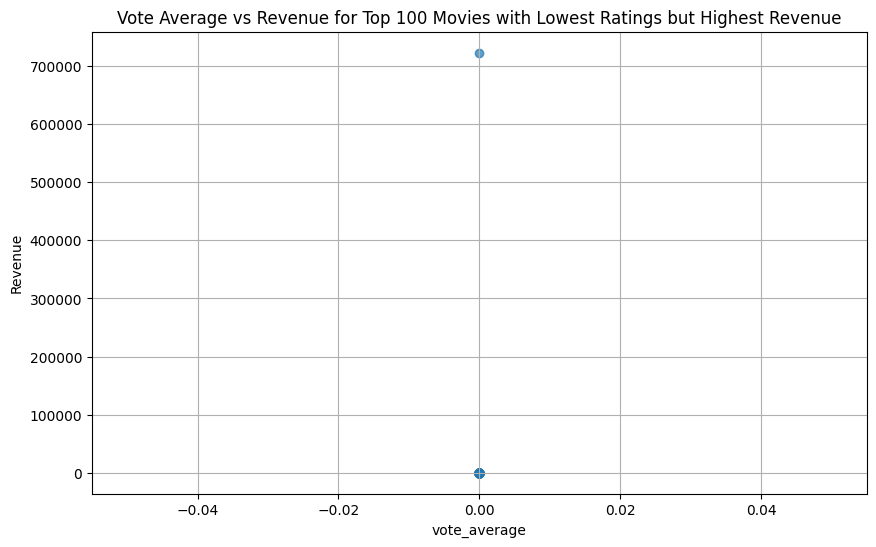

In [21]:
# Step 1: Ensure columns are in the correct format
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['vote_average'] = pd.to_numeric(df['vote_average'], errors='coerce')
df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce')

# Drop rows with NaNs in critical columns for this analysis
df = df.dropna(subset=['release_date', 'vote_average', 'revenue', 'overview', 'title'])

# Step 2: Sort by rating (ascending) and then by revenue (descending)
df_sorted = df.sort_values(by=['vote_average', 'revenue'], ascending=[True, False])

# Step 3: Select the top 100 movies with the lowest rating but highest revenue
top_100_movies = df_sorted.head(100)

# Step 4: Select the required columns
result = top_100_movies[['title', 'release_date', 'vote_average', 'revenue', 'overview']]

# Configure pandas to display all rows in the result
pd.set_option('display.max_rows', 100)

# Display the result
print(result)



In [23]:
# Create new columns for release month and year
df['release_month'] = df['release_date'].dt.month
df['release_year'] = df['release_date'].dt.year
df['release_day'] = df['release_date'].dt.month

# Display the DataFrame to verify the changes
print(df.head())

          id               title  vote_average  vote_count    status  \
210   530915 1917-01-01 00:00:00         7.990       11395  Released   
214    14161 2012-01-01 00:00:00         5.819       11300  Released   
1775  452507 1922-01-01 00:00:00         5.939        2522  Released   
3091  269795 2024-05-21 02:22:00         5.963        1344  Released   
3859  252178 2071-01-01 00:00:00         6.774        1026  Released   

     release_date    revenue  runtime  adult  \
210    2019-12-25  394638258      119  False   
214    2009-10-10  791217826      158  False   
1775   2017-10-20          0      102  False   
3091   2017-06-29    3945729       99  False   
3859   2014-10-10    3200000       99  False   

                         backdrop_path  ...  \
210   /2WgieNR1tGHlpJUsolbVzbUbE1O.jpg  ...   
214   /pvxmYJcgrLiYC6G2IQTn1PPNems.jpg  ...   
1775  /3uwyXMZN93PRkShUxvLrufwVAc2.jpg  ...   
3091  /1HoDcETfVD3AjcmWxcCVwu5MGj8.jpg  ...   
3859  /aTloiKdNs2c8vlstbx3wBWD6Thi.jpg  ...

In [25]:
# Step 1: Calculate revenue percentiles
revenue_percentiles = df['revenue'].quantile(0.995)

# Step 2: Filter data for movies in the top 0.5 percentile of revenue
top_revenue_movies = df[df['revenue'] >= revenue_percentiles]

# Step 3: Extract day and month from release_date
top_revenue_movies.loc[:, 'release_day'] = top_revenue_movies['release_date'].dt.day
top_revenue_movies.loc[:, 'release_month'] = top_revenue_movies['release_date'].dt.month

# Step 4: Aggregate by day and month
day_counts = top_revenue_movies['release_day'].value_counts()
month_counts = top_revenue_movies['release_month'].value_counts()

# Step 5: Identify top days and months
top_days = day_counts[day_counts == day_counts.max()].index.tolist()
top_months = month_counts[month_counts == month_counts.max()].index.tolist()

print("Top Days with Movies Released in Top 0.5 Percentile of Revenue:", top_days)
print("Top Months with Movies Released in Top 0.5 Percentile of Revenue:", top_months)

Top Days with Movies Released in Top 0.5 Percentile of Revenue: [25, 10, 14]
Top Months with Movies Released in Top 0.5 Percentile of Revenue: [12]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
file_path = "C:/Users/Computer Soul/Downloads/archive/TMDB_movie_dataset_v11.csv"
df = pd.read_csv(file_path)

# Assuming 'df' is your DataFrame with columns 'genre' and 'revenue'

# Step 1: Sort Data by Revenue
df_sorted = df.sort_values(by='revenue', ascending=False)

# Step 2: Calculate Revenue Threshold
revenue_threshold = df_sorted['revenue'].quantile(0.9)

# Step 3: Filter Top 10 Percentile Movies
top_10_percentile_movies = df_sorted[df_sorted['revenue'] >= revenue_threshold]

# Step 4: Plot Top 10 Percentile Movies by Genre
plt.figure(figsize=(10, 6))
plt.bar(top_10_percentile_movies['genres'].astype(str), top_10_percentile_movies['revenue'])
plt.title('Top 10 Percentile Movies by Genre')
plt.xlabel('Genres')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.show()

In [3]:
import pandas as pd

def top_movies_by_revenue_on_date(df, input_date):
    # Step 2: Convert to Pandas Timestamp
    input_timestamp = pd.to_datetime(input_date, format='%d-%m-%Y')

    # Step 3: Filter Data for Movies Released on the Same Day of the Year
    same_day_movies = df[df['release_date'].dt.dayofyear == input_timestamp.dayofyear]

    if same_day_movies.empty:
        print("No movies released on this day.")
        return
    
    # Step 4: Sort by Revenue in Descending Order
    sorted_movies = same_day_movies.sort_values(by='revenue', ascending=False)

    # Step 5: Select Top 10 Movies by Revenue
    top_10_movies = sorted_movies.head(10)

    # Step 6: Display Results
    print("Top 10 Movies by Revenue Released on", input_timestamp.strftime('%d-%m-%Y'))
    for index, row in top_10_movies.iterrows():
        print(f"{row['title']} - Revenue: ${row['revenue']}")